In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import ast
from datetime import datetime, timedelta
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import os
# Load your data
file_path1 = "preprocessed_forum_data5.pkl"
stock_data = pd.read_pickle("Finance_data.pkl")

# Display the first few rows to understand the structure



## Reading data

In [2]:
# Start time to measure execution duration
start_time = time.time()

def read_pickle(file_path):
    """
    Read a pickle file.

    Parameters:
        file_path (str): The file path of the pickle file to be read.

    Returns:
        pd.DataFrame: A DataFrame containing the data read from the pickle file.
    """
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print(f"File {file_path} not found.")
        df = None
    except Exception as e:
        print(f"Error reading the pickle file {file_path}:", e)
        df = None
    return df

# Read the dataset from the pickle file
data_df = read_pickle(file_path1)

# Check if the DataFrame is loaded successfully
if data_df is not None:
    # Display the first few rows to inspect the data
    print("First few rows of DataFrame:")
    print(data_df.head())

else:
    print("Data could not be loaded properly.")
forum_data = data_df.copy()

First few rows of DataFrame:
  Created At  Visits  Replies  Users  Post Likes           Timestamp  Likes  \
0 2018-05-01   19000       71     48         545 2018-05-18 11:50:00      0   
1 2018-05-01   19000       71     48         545 2018-05-18 11:55:00      0   
2 2018-05-01   19000       71     48         545 2018-05-18 12:59:00      0   
3 2018-05-01   19000       71     48         545 2018-05-20 05:13:00      0   
4 2018-05-01   19000       71     48         545 2018-05-20 14:26:00      0   

                                             Comment  \
0  ostin comptelia ja nokia osti sen pois seuraav...   
1  mä holdasin comptelia kauan ennen kuin nokia o...   
2  nokia aiheeseen liittyen ostin nokiaa juuri en...   
3  no neste 2017 ylivoimainen oston sattuessa hal...   
4  mä oon ollut reveniossa pitkään ja nokia alkuv...   

                                          Comment ID  \
0  https://keskustelut.inderes.fi/t/onnistumiset-...   
1  https://keskustelut.inderes.fi/t/onnistumise

In [3]:
# Step 1: Handle NaNs and ensure 'Matched Companies Info' is a list
forum_data['Matched Companies Info'] = forum_data['Matched Companies Info'].fillna("[]")

# Step 2: Convert the string representation of lists to actual lists
forum_data['Matched Companies Info'] = forum_data['Matched Companies Info'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Step 3: Extract the first company name from each list
forum_data_exploded = forum_data.explode('Matched Companies Info')

# Extract the company name from the exploded lists
def extract_company(matched_info):
    if isinstance(matched_info, tuple) and len(matched_info) > 1:
        return matched_info[1]
    return None

# Create a new 'Company' column after exploding
forum_data_exploded['Company'] = forum_data_exploded['Matched Companies Info'].apply(extract_company)


In [4]:
forum_data_exploded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12598 entries, 0 to 10164
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Created At              12578 non-null  datetime64[ns]
 1   Visits                  12598 non-null  int64         
 2   Replies                 12598 non-null  int64         
 3   Users                   12598 non-null  int64         
 4   Post Likes              12598 non-null  int64         
 5   Timestamp               12598 non-null  datetime64[ns]
 6   Likes                   12598 non-null  int64         
 7   Comment                 12598 non-null  object        
 8   Comment ID              12598 non-null  object        
 9   Matched Companies Info  12598 non-null  object        
 10  Sentiment               12598 non-null  object        
 11  Company                 12598 non-null  object        
dtypes: datetime64[ns](2), int64(5), object(5)
memo

In [5]:
forum_data_exploded.head(20)

,Created At,Visits,Replies,Users,Post Likes,Timestamp,Likes,Comment,Comment ID,Matched Companies Info,Sentiment,Company
0,2018-05-01,19000,71,48,545,2018-05-18 11:50:00,0,ostin comptelia ja nokia osti sen pois seuraav...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Nokia, Nokia Corporation, True)",NEUTRAL,Nokia Corporation
1,2018-05-01,19000,71,48,545,2018-05-18 11:55:00,0,mä holdasin comptelia kauan ennen kuin nokia o...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Nokia, Nokia Corporation, True)",NEUTRAL,Nokia Corporation
2,2018-05-01,19000,71,48,545,2018-05-18 12:59:00,0,nokia aiheeseen liittyen ostin nokiaa juuri en...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Nokia, Nokia Corporation, True)",NEUTRAL,Nokia Corporation
3,2018-05-01,19000,71,48,545,2018-05-20 05:13:00,0,no neste 2017 ylivoimainen oston sattuessa hal...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Neste, Neste Oyj, True)",NEUTRAL,Neste Oyj
4,2018-05-01,19000,71,48,545,2018-05-20 14:26:00,0,mä oon ollut reveniossa pitkään ja nokia alkuv...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Nokia, Nokia Corporation, True)",POSITIVE,Nokia Corporation
4,2018-05-01,19000,71,48,545,2018-05-20 14:26:00,0,mä oon ollut reveniossa pitkään ja nokia alkuv...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Reveniossa, Revenio Group Oyj, True)",POSITIVE,Revenio Group Oyj
5,2018-05-01,19000,71,48,545,2019-09-12 15:25:00,0,huomasin juuri salkun olevan athlukemissa mets...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Sampoa, Sampo Oyj, True)",NEUTRAL,Sampo Oyj
6,2018-05-01,19000,71,48,545,2019-09-29 20:40:00,0,kyllä mun mielestä lapsen salkussa jossa summa...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(nokia, Nokia Corporation, True)",NEUTRAL,Nokia Corporation
7,2018-05-01,19000,71,48,545,2019-09-29 21:26:00,0,okei mennyt kyllä kuin oppikirjassa kun noinki...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(Talenomiin, Talenom Oyj, True)",POSITIVE,Talenom Oyj
8,2018-05-01,19000,71,48,545,2020-08-14 10:11:00,0,alkukeväästä nohon rahat vaihdettu remedyyn yl...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(NoHon, NoHo Partners Oyj, True)",NEUTRAL,NoHo Partners Oyj


In [6]:

# Extract year and month
forum_data_exploded['Year'] = forum_data_exploded['Created At'].dt.year
forum_data_exploded['Month'] = forum_data_exploded['Created At'].dt.month

forum_data_exploded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12598 entries, 0 to 10164
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Created At              12578 non-null  datetime64[ns]
 1   Visits                  12598 non-null  int64         
 2   Replies                 12598 non-null  int64         
 3   Users                   12598 non-null  int64         
 4   Post Likes              12598 non-null  int64         
 5   Timestamp               12598 non-null  datetime64[ns]
 6   Likes                   12598 non-null  int64         
 7   Comment                 12598 non-null  object        
 8   Comment ID              12598 non-null  object        
 9   Matched Companies Info  12598 non-null  object        
 10  Sentiment               12598 non-null  object        
 11  Company                 12598 non-null  object        
 12  Year                    12578 non-null  float6

## Merging finance and forum data together

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Timestamp' in forum data and 'Date' in stock data are in datetime format
forum_data_exploded['Timestamp'] = pd.to_datetime(forum_data_exploded['Timestamp'], errors='coerce')
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

# Create 'Year' and 'Month' columns from 'Timestamp' and 'Date'
forum_data_exploded['Year'] = forum_data_exploded['Timestamp'].dt.year
forum_data_exploded['Month'] = forum_data_exploded['Timestamp'].dt.month
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Month'] = stock_data['Date'].dt.month

# Strip and align 'Company' columns in both datasets
forum_data_exploded['Company'] = forum_data_exploded['Company'].str.strip()
stock_data['Company'] = stock_data['Company'].str.strip()

# Merge on 'Year', 'Month', and 'Company'
merged_data = pd.merge(
    forum_data_exploded,
    stock_data,
    left_on=['Year', 'Month', 'Company'],
    right_on=['Year', 'Month', 'Company'],
    how='inner'
)

# Check the structure of the merged data
print(merged_data.head())


  Created At    Visits  Replies  Users  Post Likes           Timestamp  Likes  \
0 2018-05-01     19000       71     48         545 2019-09-12 15:25:00      0   
1 2018-11-01  21000000     6100    740       74200 2019-09-01 10:23:00      0   
2 2018-11-01  21000000     6100    740       74200 2019-09-01 16:50:00      0   
3 2018-11-01  21000000     6100    740       74200 2019-09-02 18:51:00      0   
4 2018-11-01  21000000     6100    740       74200 2019-09-02 19:14:00      0   

                                             Comment  \
0  huomasin juuri salkun olevan athlukemissa mets...   
1  juu kone on hissillä ylimmässä kerroksessa mit...   
2  hyvä pointti nordeasta putsattuna sampo ei eri...   
3  httpswwwtaalerivarainhoitocomajankohtaistasijo...   
4  sampo suomalaisen pääoman ikoni ei kriisiydy e...   

                                          Comment ID  \
0  https://keskustelut.inderes.fi/t/onnistumiset-...   
1  https://keskustelut.inderes.fi/t/sampo-vakuutt...   
2  https

In [8]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11837 entries, 0 to 11836
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Created At              11837 non-null  datetime64[ns]
 1   Visits                  11837 non-null  int64         
 2   Replies                 11837 non-null  int64         
 3   Users                   11837 non-null  int64         
 4   Post Likes              11837 non-null  int64         
 5   Timestamp               11837 non-null  datetime64[ns]
 6   Likes                   11837 non-null  int64         
 7   Comment                 11837 non-null  object        
 8   Comment ID              11837 non-null  object        
 9   Matched Companies Info  11837 non-null  object        
 10  Sentiment               11837 non-null  object        
 11  Company                 11837 non-null  object        
 12  Year                    11837 non-null  int64 

## Lets take a look at the data that we have

In [9]:
# Ensure the "Timestamp" column is in datetime format
merged_data['Timestamp'] = pd.to_datetime(merged_data['Timestamp'], errors='coerce')

# Extract the year from the "Timestamp" column
merged_data['Year'] = merged_data['Timestamp'].dt.year


In [10]:
# Group by year and count observations
observations_per_year = merged_data.groupby('Year').size()

# Display the number of observations per year
print("Number of observations per year:")
print(observations_per_year)                                                       


Number of observations per year:
Year
2019    1624
2020    3938
2021    2591
2022    1816
2023    1868
dtype: int64


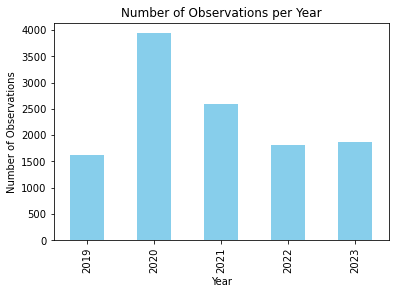

In [11]:
import matplotlib.pyplot as plt

# Plot the number of observations per year
observations_per_year.plot(kind='bar', title='Number of Observations per Year', color='skyblue')
plt.xlabel("Year")
plt.ylabel("Number of Observations")
plt.show()


In [12]:
# Group by company and count observations
observations_per_company = merged_data.groupby('Company').size()

# Get the top 10 companies by number of observations
top_10_companies = observations_per_company.sort_values(ascending=False).head(10)

print("Top 10 companies with the most observations:")
print(top_10_companies)


Top 10 companies with the most observations:
Company
Nokia Corporation     1133
Fortum Oyj             569
Nokian Renkaat Oyj     558
Valmet Oyj             519
Sampo Oyj              504
Kesko Oyj              460
Tokmanni Group Oyj     409
Revenio Group Oyj      407
Talenom Oyj            357
Cargotec Corp          333
dtype: int64


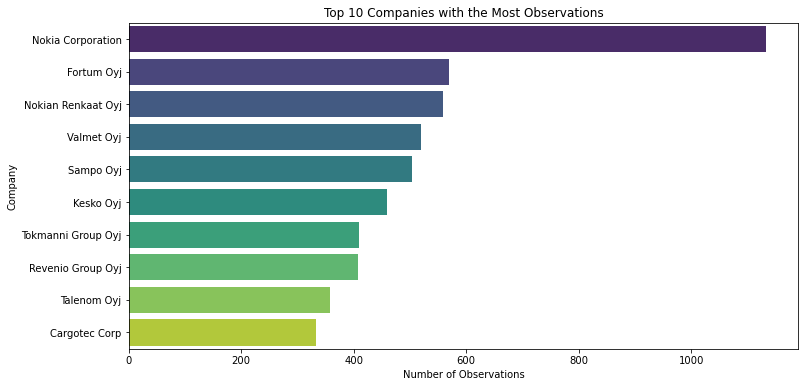

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the number of observations for the top 10 companies
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_companies.values, y=top_10_companies.index, palette="viridis")
plt.xlabel("Number of Observations")
plt.ylabel("Company")
plt.title("Top 10 Companies with the Most Observations")
plt.show()



## Filtering dataset to include only rows dealing with Nokia corporation

In [84]:
# Filter the dataset to include only Nokia Corporation
nokia_data = merged_data[merged_data['Company'].str.contains("Nokia Corporation", case=False, na=False)]

# Check the filtered data
nokia_data.info()
nokia_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1133 entries, 14 to 10297
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Created At              1133 non-null   datetime64[ns]
 1   Visits                  1133 non-null   int64         
 2   Replies                 1133 non-null   int64         
 3   Users                   1133 non-null   int64         
 4   Post Likes              1133 non-null   int64         
 5   Timestamp               1133 non-null   datetime64[ns]
 6   Likes                   1133 non-null   int64         
 7   Comment                 1133 non-null   object        
 8   Comment ID              1133 non-null   object        
 9   Matched Companies Info  1133 non-null   object        
 10  Sentiment               1133 non-null   object        
 11  Company                 1133 non-null   object        
 12  Year                    1133 non-null   int64 

,Created At,Visits,Replies,Users,Post Likes,Timestamp,Likes,Comment,Comment ID,Matched Companies Info,...,Company,Year,Month,Date,Open,High,Low,Close,Adj Close,Volume
14,2018-05-01,19000,71,48,545,2019-09-29 20:40:00,0,kyllä mun mielestä lapsen salkussa jossa summa...,https://keskustelut.inderes.fi/t/onnistumiset-...,"(nokia, Nokia Corporation, True)",...,Nokia Corporation,2019,9,2019-09-01,4.5,4.829,4.414,4.65,4.41412,270529286
15,2018-07-01,34700,84,47,1300,2019-09-10 15:11:00,0,nokiaanalyytikko mikael rautanen avaa jälleen ...,https://keskustelut.inderes.fi/t/inderesvaen-o...,"(Nokia, Nokia Corporation, True)",...,Nokia Corporation,2019,9,2019-09-01,4.5,4.829,4.414,4.65,4.41412,270529286
16,2018-07-01,34700,84,47,1300,2019-09-10 19:39:00,0,nokiaanalyytikko mikael rautanen avaa jälleen ...,https://keskustelut.inderes.fi/t/inderesvaen-o...,"(Nokia, Nokia Corporation, True)",...,Nokia Corporation,2019,9,2019-09-01,4.5,4.829,4.414,4.65,4.41412,270529286
17,2018-05-01,71600,647,121,1900,2019-09-23 14:45:00,0,tällä hetkellä salkkuni parhaiten menestynyt o...,https://keskustelut.inderes.fi/t/suomen-hoivat...,"(Nokian, Nokia Corporation, True)",...,Nokia Corporation,2019,9,2019-09-01,4.5,4.829,4.414,4.65,4.41412,270529286
18,2018-07-01,25800,174,46,336,2019-09-13 10:09:00,0,fb ei ole kurssin palautumisen jälkeen herättä...,https://keskustelut.inderes.fi/t/some-jatit-fb...,"(Nokian, Nokia Corporation, True)",...,Nokia Corporation,2019,9,2019-09-01,4.5,4.829,4.414,4.65,4.41412,270529286


## Feature engineering

In [23]:
# Calculate monthly sentiment counts for Nokia
grouped_by_month = nokia_data.groupby(['Year', 'Month'])
nokia_monthly_sentiment = grouped_by_month['Sentiment'].value_counts().unstack(fill_value=0)
# Calculate average stock prices
nokia_average_monthly_prices = grouped_by_month[['Open', 'Close', 'Adj Close']].mean()

# Calculate monthly stock price changes
nokia_monthly_price_changes = nokia_average_monthly_prices.diff()
# Calculate monthly engagement metrics
nokia_monthly_engagement = grouped_by_month[['Visits', 'Replies', 'Users', 'Post Likes']].sum()


In [26]:
# Combine the engineered features into a single DataFrame
nokia_monthly_features = pd.concat(
    [
        nokia_monthly_sentiment,
        nokia_average_monthly_prices,
        nokia_monthly_price_changes,
        nokia_monthly_engagement
    ],
    axis=1
)

# Reset the index to get a clear structure
nokia_monthly_features.reset_index(inplace=True)

# Assign descriptive names to the features
nokia_monthly_features.columns = [
    'Year', 'Month', 'Negative_Sentiments', 'Neutral_Sentiments', 'Positive_Sentiments',
    'Avg_Open', 'Avg_Close', 'Avg_Adj_Close',
    'Price_Change_Open', 'Price_Change_Close', 'Price_Change_Adj_Close',
    'Total_Visits', 'Total_Replies', 'Total_Users', 'Total_Post_Likes'
]


In [29]:
# Create a "Year-Month" representation
nokia_monthly_features['Year-Month'] = nokia_monthly_features['Year'].astype(str) + "-" + nokia_monthly_features['Month'].astype(str).str.zfill(2)

# Check the new column to ensure it's correct
print(nokia_monthly_features['Year-Month'].head())


0    2019-01
1    2019-02
2    2019-03
3    2019-04
4    2019-05
Name: Year-Month, dtype: object


In [30]:
# Display the structure of the DataFrame
print(nokia_monthly_features.info())

# Show the first few rows of the data
print(nokia_monthly_features.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Year                    60 non-null     int64  
 1   Month                   60 non-null     int64  
 2   Negative_Sentiments     60 non-null     int64  
 3   Neutral_Sentiments      60 non-null     int64  
 4   Positive_Sentiments     60 non-null     int64  
 5   Avg_Open                60 non-null     float64
 6   Avg_Close               60 non-null     float64
 7   Avg_Adj_Close           60 non-null     float64
 8   Price_Change_Open       59 non-null     float64
 9   Price_Change_Close      59 non-null     float64
 10  Price_Change_Adj_Close  59 non-null     float64
 11  Total_Visits            60 non-null     int64  
 12  Total_Replies           60 non-null     int64  
 13  Total_Users             60 non-null     int64  
 14  Total_Post_Likes        60 non-null     int6

In [32]:
# Filter the data for the year 2020
nokia_2020 = nokia_monthly_features[nokia_monthly_features['Year'] == 2020]

# Check the structure of the 2020 data
print(nokia_2020.info())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 12 to 23
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Year                    12 non-null     int64  
 1   Month                   12 non-null     int64  
 2   Negative_Sentiments     12 non-null     int64  
 3   Neutral_Sentiments      12 non-null     int64  
 4   Positive_Sentiments     12 non-null     int64  
 5   Avg_Open                12 non-null     float64
 6   Avg_Close               12 non-null     float64
 7   Avg_Adj_Close           12 non-null     float64
 8   Price_Change_Open       12 non-null     float64
 9   Price_Change_Close      12 non-null     float64
 10  Price_Change_Adj_Close  12 non-null     float64
 11  Total_Visits            12 non-null     int64  
 12  Total_Replies           12 non-null     int64  
 13  Total_Users             12 non-null     int64  
 14  Total_Post_Likes        12 non-null     int

## Exploratory data analysis

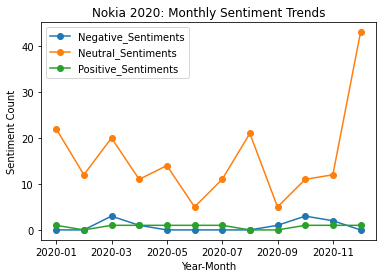

In [33]:
import matplotlib.pyplot as plt

# Plot sentiment trends for 2020
nokia_2020.plot(x='Year-Month', y=['Negative_Sentiments', 'Neutral_Sentiments', 'Positive_Sentiments'], kind='line', marker='o', title='Nokia 2020: Monthly Sentiment Trends')
plt.xlabel("Year-Month")
plt.ylabel("Sentiment Count")
plt.show()


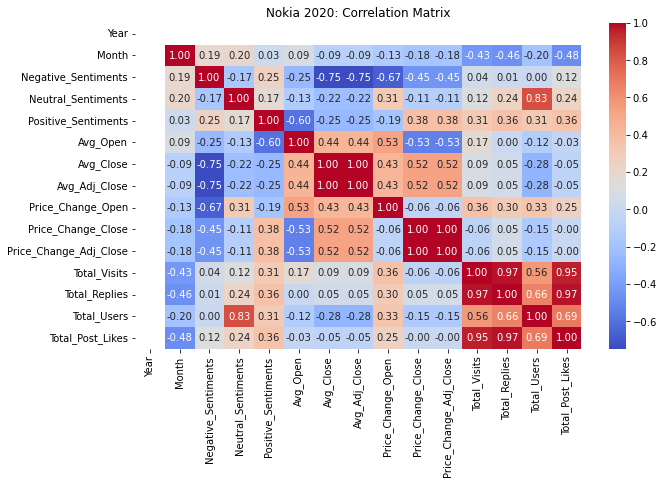

In [37]:
import seaborn as sns

# Calculate the correlation matrix for 2020
nokia_2020_correlation_matrix = nokia_2020.corr()

# Visualize the correlation matrix for 2020
plt.figure(figsize=(10, 6))
sns.heatmap(nokia_2020_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Nokia 2020: Correlation Matrix")
plt.show()


In [115]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Define the stock movement
nokia_monthly_features['Stock_Movement'] = nokia_monthly_features['Price_Change_Adj_Close'].apply(
    lambda x: 'Up' if x > 0 else 'Down' if x < 0 else 'Same'
)
# List of engineered features to use in predictive analytics
features = [
    'Negative_Sentiments', 'Neutral_Sentiments', 'Positive_Sentiments',  # Sentiment-based features
    'Avg_Open', 'Avg_Close', 'Avg_Adj_Close',                             # Stock price-based features
    'Total_Visits', 'Total_Replies', 'Total_Users', 'Total_Post_Likes'    # Engagement-based features
]
# Define the target variable
target = 'Stock_Movement'  # 'Up', 'Down', or 'Same'
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    nokia_monthly_features[features],  # Use the engineered features
    nokia_monthly_features[target],   # Use the target variable
    test_size=0.3,  # Allocate 30% of the data for testing
    random_state=42  # Ensures reproducibility
)
# Train a Random Forest classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
# Test the model and evaluate its performance
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_rep)


Model Accuracy: 0.4444444444444444
Confusion Matrix:
[[4 0 4]
 [1 0 0]
 [5 0 4]]
Classification Report:
              precision    recall  f1-score   support

        Down       0.40      0.50      0.44         8
        Same       0.00      0.00      0.00         1
          Up       0.50      0.44      0.47         9

    accuracy                           0.44        18
   macro avg       0.30      0.31      0.31        18
weighted avg       0.43      0.44      0.43        18



C:\Users\mehta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mehta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mehta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


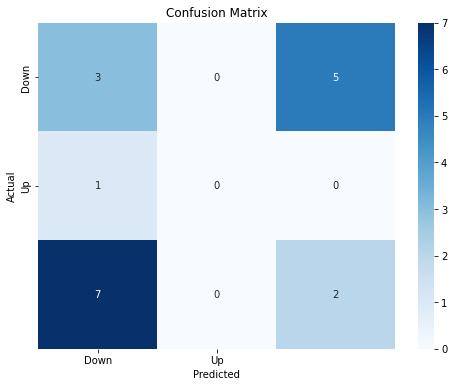

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


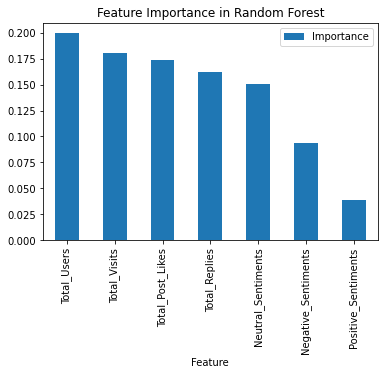

In [75]:
# Get feature importance from the Random Forest model
feature_importance = model.feature_importances_

# Create a DataFrame to organize the feature importance
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# Plot the feature importance
feature_importance_df.sort_values(by='Importance', ascending=False).plot(
    kind='bar', x='Feature', y='Importance', title='Feature Importance in Random Forest'
)
plt.show()


In [99]:
import advertools as adv
adv.stopwords.keys()

dict_keys(['arabic', 'azerbaijani', 'bengali', 'catalan', 'chinese', 'croatian', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hindi', 'hungarian', 'indonesian', 'irish', 'italian', 'japanese', 'kazakh', 'nepali', 'norwegian', 'persian', 'polish', 'portuguese', 'romanian', 'russian', 'sinhala', 'spanish', 'swedish', 'tagalog', 'tamil', 'tatar', 'telugu', 'thai', 'turkish', 'ukrainian', 'urdu', 'vietnamese'])

In [112]:


# Get the list of English and Finnish stopwords
english_stopwords = adv.stopwords['english']
finnish_stopwords = adv.stopwords['finnish']

# Combine both sets of stopwords
combined_stopwords = set(english_stopwords) | set(finnish_stopwords)
# Update combined stopwords to include "nokia" and "nokian"
additional_stopwords = {"nokia", "nokian", "nokiaa", "yhtiö", "yhtiön"}  # Set with specific terms to remove
combined_stopwords = combined_stopwords | additional_stopwords  # Add these to existing stopwords


In [105]:
import spacy

# Load the Finnish language model
nlp = spacy.load("fi_core_news_sm")

# Function to lemmatize text
def lemmatize_text(text):
    # Process the text with the language model
    doc = nlp(text)
    # Extract the lemma for each token
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

# Apply lemmatization to the text data
nokia_data['Lemmatized_Comment'] = nokia_data['Comment'].apply(lemmatize_text)


<ipython-input-105-0c410dd9d573>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nokia_data['Lemmatized_Comment'] = nokia_data['Comment'].apply(lemmatize_text)


In [113]:
# Preprocess the comments to remove specific terms
nokia_data['Processed_Comment'] = nokia_data['Comment'].apply(
    lambda text: " ".join([word for word in text.split() if word.lower() not in combined_stopwords])
)


<ipython-input-113-78741eb9116a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nokia_data['Processed_Comment'] = nokia_data['Comment'].apply(


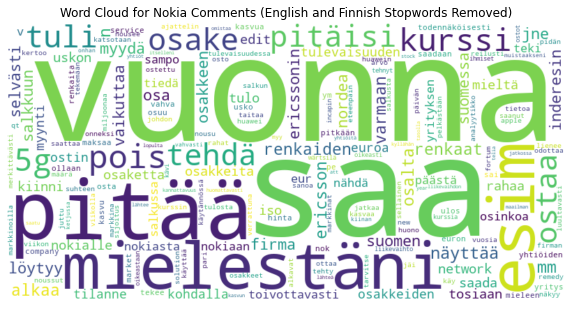

In [114]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all preprocessed comments into one text
combined_text = ' '.join(nokia_data['Processed_Comment'])

# Generate a word cloud with both English and Finnish stopwords removed
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=combined_stopwords  # Using combined stopwords
).generate(combined_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Nokia Comments (English and Finnish Stopwords Removed)")
plt.show()
